These are experiments to visualize how the VMM implementation using Kaitlin Fair's method scales as we increase the matrix as well as change the number of neurons and axons in a core.

### Mathematical Relationships

Currently a VMM can be created with the following number of cores:

\begin{align}
    num\_rep\_cores & = 3 \left\lceil \frac{num\_neurons\_per\_column \cdot w}{num\_neurons} \right\rceil \\
    num\_splitter\_cores & = \left\lceil \frac{num\_rep\_cores}{\left\lfloor  \frac{min(num\_neurons, num\_axons)}{4h} \right\rfloor} \right\rceil \\
    num\_cores & = num\_splitter\_cores + num\_rep\_cores
\end{align}

So if we make the assumption that the number of number of neurons are always going to be equal to the number of axons (This might actually be a constraint, need to think about it more) and we relax the ceiling and floor functions we can get the following :

$\alpha$ = num_neurons, $\beta$ = num_neurons_per_column, $\gamma$ = num_cores

\begin{align}
    \gamma(w, h, \alpha, \beta) & = \frac{3 \beta w}{\alpha} + \frac{4 \beta h w }{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial w} & = \frac{3 \beta}{\alpha} + \frac{4 \beta h}{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial h} & =  \frac{4 \beta w}{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial \alpha} & = -\frac{3 \beta w}{\alpha ^ 2} - \frac{8 \beta h w}{\alpha ^ 3} \\
    \frac{\partial \gamma}{\partial \beta} & =  \frac{3 w}{\alpha} + \frac{4 h w }{\alpha ^ 2} \\
\end{align}

If there is feedback in the first core then we need 32 neurons per matrix column which will give us:

\begin{align}
    \gamma(w, h, \alpha) & = \frac{96w}{\alpha} + \frac{128hw}{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial w} & = \frac{96}{\alpha} + \frac{128h}{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial h} & =  \frac{128w}{\alpha ^ 2} \\
    \frac{\partial \gamma}{\partial \alpha} & = -\frac{96w}{\alpha ^ 2} - \frac{256hw}{\alpha ^ 3}
\end{align}



### Code used to obtain the number of cores

Don't use it for anything in this notebook as using the analytical equation is easier but this could be useful because it is how it would actually be mapped. 

In [1]:
NUM_REP_NEURONS_PER_ELEMENT = 16

NUM_AXONS_PER_INPUT = 4

def get_core_count(
        width, 
        height,
        first_core_feedback = True,
        num_neurons = 256, 
        num_axons = 256):
    
    if first_core_feedback:
        num_feedback_neurons_per_element = 16
    else:
        num_feedback_neurons_per_element = 0
    num_neurons_per_element = NUM_REP_NEURONS_PER_ELEMENT + num_feedback_neurons_per_element
    max_width_per_corelet = num_neurons // num_neurons_per_element
    num_representation_axons_per_corelet = NUM_AXONS_PER_INPUT * height + num_feedback_neurons_per_element * min(max_width_per_corelet, width)
    num_representation_neurons = num_neurons_per_element * width
    num_corelets = math.ceil(num_representation_neurons / num_neurons)
    num_corelets_per_splitter = math.floor(min(num_neurons, num_axons) / (NUM_AXONS_PER_INPUT * height))
    num_splitter_cores = math.ceil(num_corelets / num_corelets_per_splitter)
    return num_splitter_cores + num_corelets * 3 # Counting output bus as a core

### Scaling matrix with 256 axons and 256 neurons

<IPython.core.display.Javascript object>


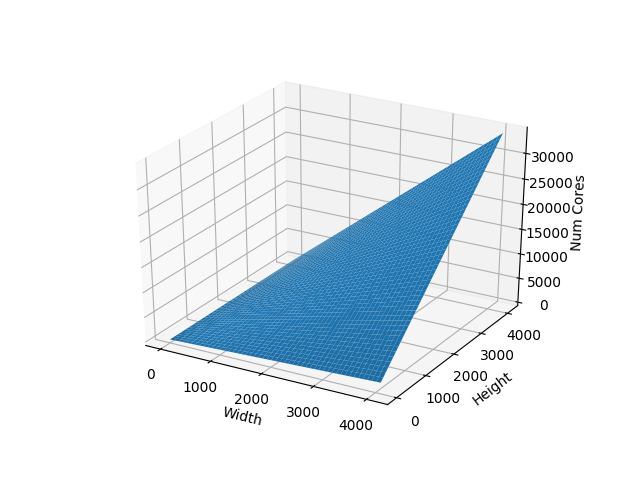

In [2]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# If we set the number of axons = number of neurons
def get_core_count_analytical(
        w, 
        h, 
        num_neurons_per_column = 32,
        num_neurons = 256):
    return 3 * num_neurons_per_column * w / num_neurons + 4 * num_neurons_per_column * w * h / num_neurons ** 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Getting data for function
w = np.linspace(0, 4096)
h = np.linspace(0, 4096)
W, H = np.meshgrid(w, h)
z = np.array([get_core_count_analytical(w,h, num_neurons_per_column = 32) for w,h in zip(np.ravel(W), np.ravel(H))])
Z = z.reshape(W.shape)

ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_zlabel('Num Cores')
ax.plot_surface(W, H, Z);

fig.savefig("3DPlotNumCores.png")



### Increasing the number neurons

Now want to look at how the number of cores and the resources for a particular configuration will be effected by increasing the number of neurons / axons. Getting the number of cores is easy using the analytical solution above, and running some sweeping experiments allows me to populate a dictionary which shows the number of resources a single core with increasing number of neurons and axons consumes.

<IPython.core.display.Javascript object>


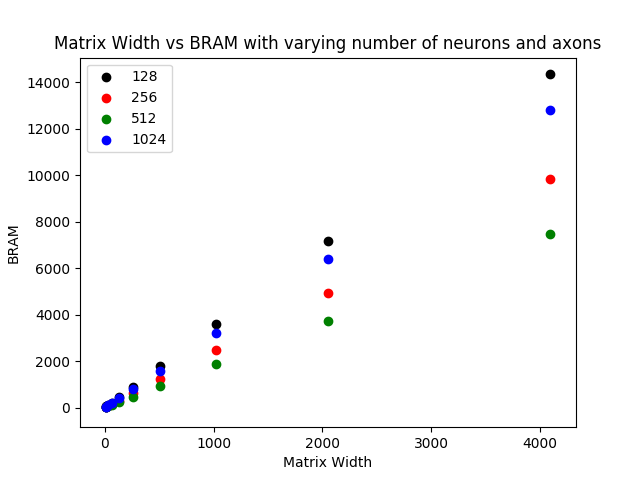

<IPython.core.display.Javascript object>


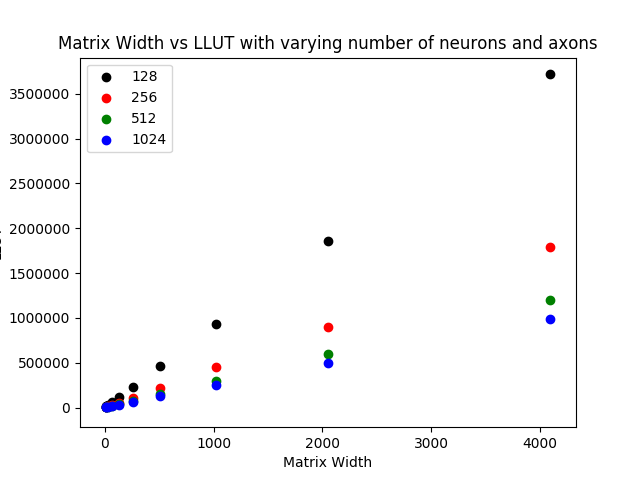

<IPython.core.display.Javascript object>


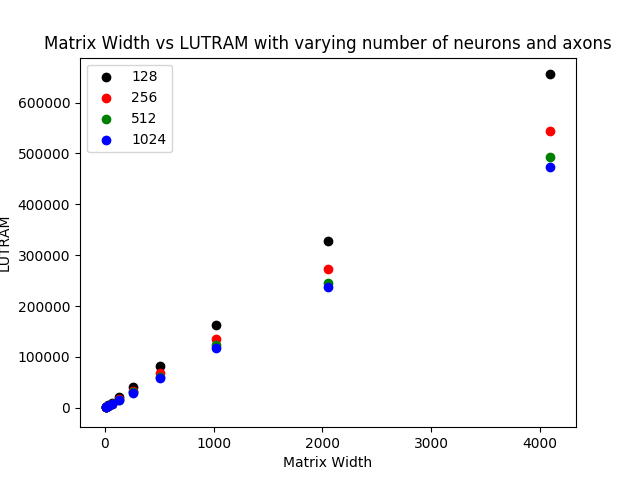

In [3]:
num_neuron_list = [128, 256, 512, 1024]
color_list = ['k', 'r', 'g', 'b', 'c', 'm']
width_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
height = 32

# Ran parameter sweep to obtain these values
resource_dict = {
    128: {
        'BRAM': 3.5,
        'LLUT': 907,
        'LUTRAM': 160
    },
    256: {
        'BRAM': 5.5,
        'LLUT': 998,
        'LUTRAM': 304
    },
    512: {
        'BRAM': 9,
        'LLUT': 1444,
        'LUTRAM': 592
    },
    1024: {
        'BRAM': 32,
        'LLUT': 2473,
        'LUTRAM': 1184
    }
}

# Getting Resource Usage

for resource in ['BRAM', 'LLUT', 'LUTRAM']:
    plt.figure()
    for num_neurons, color in zip(num_neuron_list, color_list):
        resource_list = []
        for width in width_list:
            num_cores = get_core_count_analytical(width, height, num_neurons_per_column = 32, num_neurons = num_neurons)
            resource_list.append(num_cores * resource_dict[num_neurons][resource])

        plt.scatter(width_list, resource_list, c = color, label = num_neurons)

    plt.legend()
    plt.title("Matrix Width vs {} with varying number of neurons and axons".format(resource))
    plt.xscale('linear')
    plt.xlabel('Matrix Width')
    plt.ylabel(resource);
    plt.savefig("width_vs_{}.png".format(resource))

### Comparing Kaitlin's method with using Synaptic Indexing

Using synaptic indexing makes it so we can dramatically increase the size of the core in order to reduce the number of cores that we need and ultimately save resources. Here I am going to look at specifically when it starts to become worth it to use synaptic indexing by comparing the memory footprint of Kaitlin's method, symmetric reset, and synaptic indexing.  First it might be helpful to look at a single example. This is the comparison when mapping a 32x128 VMM using all three methods:

#### Kaitlin's method

Mapping a 32x128 VMM will take 16 3-core corelets and 8 splitter cores which is a total of 56 cores. A single core requires 256 * 2 bits for the Token Controller and 256 * 368 bits for the CSRAM. So all 56 cores will require: 56 * (256 * 2 + 256 * 368) = 5,304,320 bits. If we were to use symmetric reset, it would essentially be the same but we would need half the number of cores because we no longer need feedback neurons. This would require 28 cores ad 3,356,920 bits.

#### Synaptic indexing

Mapping a 32x128 VMM using synaptic indexing will take 1 core with 64 weights and log2(64) bits per synapse. This means that the number of bits for the token controller will be 256 * 256 * log2(64) and the CSRAM will be 256 * (368 + 6 * 90). This would require a total of 625,664 bits. This is a 8.48x reduction in memory footprint compared to Kaitlin's version and a 4.24x reduction when using symmetric reset

So obviously the synaptic indexing is better for this particularly large matrix, but when the matrix gets smaller Kaitlin's method will require less cores while synaptic indexing will require the same number of resources. So when does it become worth it to use synaptic indexing?

6.605405405405405
3.5
7.0
14.0
28.0
56.0


<IPython.core.display.Javascript object>


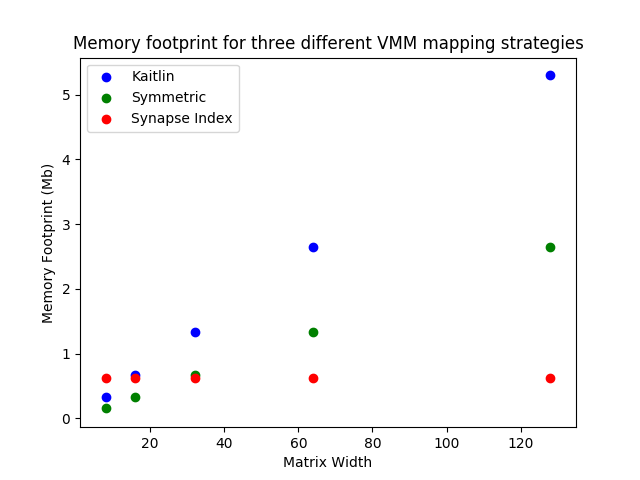

In [21]:
width_list = [8, 16, 32, 64, 128]
height = 32
single_core_mem = 256 * 2 + 256 * 368
single_core_synapse_index_mem = 256 * 256 * 6 + 256 * (368 + 9 * 60)
kaitlin_mem_list = []
symmetric_mem_list = []
synapse_index_mem_list = []

for width in width_list:
    kaitlin_num_cores = get_core_count_analytical(width, height, num_neurons_per_column = 32, num_neurons = 256)
    print(kaitlin_num_cores)
    symmetric_num_cores = get_core_count_analytical(width, height, num_neurons_per_column = 16, num_neurons = 256)
    kaitlin_mem_list.append(single_core_mem * kaitlin_num_cores / 1000000)
    symmetric_mem_list.append(single_core_mem * symmetric_num_cores / 1000000)
    synapse_index_mem_list.append(single_core_synapse_index_mem / 1000000)

plt.figure()
plt.scatter(width_list, kaitlin_mem_list, c = 'b', label = 'Kaitlin')
plt.scatter(width_list, symmetric_mem_list, c = 'g', label = 'Symmetric')
plt.scatter(width_list, synapse_index_mem_list, c = 'r', label = 'Synapse Index')

plt.legend()
plt.title("Memory footprint for three different VMM mapping strategies")
plt.xlabel('Matrix Width')
plt.ylabel('Memory Footprint (Mb)')
plt.savefig("vmm_mapping_comp.png")

When looking at this particular example, the single synaotic It would also be good to look into LUT resources on the FPGA as intuitively the synaptic indexing methodology would require much less LUTs as there is only a single router which takes up a large number of logical resources. DO THIS!!